#  Введение в рекуррентные нейронные сети

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Николенко С., Кадурин А., Архангельская Е. Глубокое обучение.
* https://pytorch.org/docs/stable/nn.html#recurrent-layers
* https://karpathy.github.io/2015/05/21/rnn-effectiveness/
* https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html
* https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

## Задачи для совместного разбора

1\. Рассмотрите пример работы одного шага простейшего рекуррентного слоя.  

$$ h' = tanh(W_{ih}x + W_{hh}h) $$

![RNN](https://kvitajakub.github.io/img/rnn-unrolled.png)

2\. Рассмотрите пример работы рекуррентных слоев из `torch.nn`.

In [2]:
import torch as th
import re 
import torch.nn as nn
import pandas as pd
import random as rd 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

In [2]:
batch_size = 16
input_size = 32
hidden_size = 10
output_size = 2

x0 = th.rand(batch_size, input_size)

In [ ]:
layer = nn.RNNCell(input_size, hidden_size)
fc = nn.Linear(hidden_size, output_size)
# h0 = th.zeros(batch_size, hidden_size)
# h1 = layer(x0, h0)
h1 = layer(x0)
o1 = fc(h1) # если нужен прогноз на уровне эл-тов последовательности

In [ ]:
x1 = th.rand(batch_size, input_size)
h2 = layer(x1, h1)
h2.shape

torch.Size([16, 10])

In [ ]:
layer = nn.RNN(input_size, hidden_size, batch_first=True)

seq_len = 8
x = th.rand(batch_size, seq_len, input_size)
o, h = layer(x)
x.shape, h.shape, o.shape

(torch.Size([16, 8, 32]), torch.Size([1, 16, 10]), torch.Size([16, 8, 10]))

In [ ]:
o[0, -1, :]

tensor([ 0.8445, -0.0823, -0.2612,  0.2798,  0.4505,  0.1560,  0.3548, -0.5396,
         0.3765, -0.1638], grad_fn=<SliceBackward0>)

In [ ]:
h[0, 0, :]

tensor([ 0.8445, -0.0823, -0.2612,  0.2798,  0.4505,  0.1560,  0.3548, -0.5396,
         0.3765, -0.1638], grad_fn=<SliceBackward0>)

In [ ]:
classifier = nn.Linear(hidden_size, output_size)
classifier(h[0, :])

tensor([[-0.4651, -0.2895],
        [-0.4656, -0.5252],
        [-0.4334, -0.4699],
        [-0.2476, -0.0420],
        [-0.6130, -0.2201],
        [-0.5095, -0.1762],
        [-0.4748, -0.2115],
        [-0.4132,  0.0756],
        [-0.6097, -0.1626],
        [-0.4429, -0.3569],
        [-0.5724, -0.0309],
        [-0.3737, -0.3389],
        [-0.4916, -0.3492],
        [-0.4752, -0.3849],
        [-0.4967, -0.0386],
        [-0.3019, -0.1266]], grad_fn=<AddmmBackward0>)

In [ ]:
layer = nn.RNN(input_size, hidden_size, batch_first=False)

seq_len = 8
x = th.rand(seq_len, batch_size, input_size)
o, h = layer(x)
x.shape, h.shape, o.shape

(torch.Size([8, 16, 32]), torch.Size([1, 16, 10]), torch.Size([8, 16, 10]))

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Используя класс `nn.RNNCell` (абстракцию для отдельного временного шага RNN), реализуйте простейшую рекуррентную сеть в виде класса `RNN`. Предусмотрите возможность работы с двумя вариантами данных: где данные (x) представлены в виде (batch, seq, feature) и где данные представлены в формате (seq, batch, feature). Создайте тензор `inputs1` размера 16 x 8 x 32 (batch, seq, feature) и пропустите через модель `RNN`. Выведите на экран форму двух полученных тензоров. Проверьте, что тензор `output[:, -1, :]` поэлементно равен `h`.

- [ ] Проверено на семинаре

In [2]:
import torch 
import re 
import torch.nn as nn
import pandas as pd
import random as rd 
import tokenizers
import matplotlib.pyplot as plt
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Split
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Sequence
from tokenizers.pre_tokenizers import Whitespace
from torch.utils.data import Dataset,DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

In [120]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, batch_first = True):
    super().__init__()
    self.batch_first = batch_first
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.check_h = None
    self.cell = nn.RNNCell(input_size,hidden_size,bias = False)
    
  def forward(self,X,h = None):
    '''
    x.shape = (batch_size, seq_len, feature_size) - тензор входных данных
    h.shape = (batch_size, hidden_size) - тензор со скрытым состоянием RNN
    '''
    # инициализация тензора скрытых состояний
    # h = ...
    h = torch.randn(X.shape[1] if self.batch_first else X.shape[0],self.hidden_size)
      
    # проход по каждому элементу последовательностей s в батче и обновление скрытого состояния
    # h = RNNCell(s_t, h)
    output = []
    for i in range(X.shape[0] if self.batch_first else X.shape[1]):
      xx = X[i] if self.batch_first else X[:,i,:]
      h = self.cell(xx,h)
      self.check_h = h
      output.append(h.unsqueeze(dim = 0 if self.batch_first else 1))
    return torch.cat(output,dim = 0 if self.batch_first else 1)
    # вернуть тензор всех наблюдавшихся скрытых состояний размера (batch_size, seq_len, hidden_size) и тензор скрытых состояний в последний момент времени

In [228]:
rnn = RNN(10,5,batch_first=True)
rnn

RNN(
  (cell): RNNCell(10, 5, bias=False)
)

In [229]:
inputs1 = torch.randn(2,5,10)
print(inputs1.shape)

torch.Size([2, 5, 10])


In [233]:
output = rnn.forward(inputs1)
print(output.shape)

torch.Size([2, 5, 5])


In [ ]:
output[-1] #because batch first

tensor([[ 0.7276,  0.5578,  0.5967, -0.0475, -0.2805],
        [-0.8931, -0.4161, -0.4394,  0.3239, -0.5008],
        [-0.8206, -0.6889,  0.3214, -0.0871, -0.5096],
        [ 0.4040, -0.5188,  0.5157, -0.9414, -0.3488],
        [ 0.3771,  0.9805, -0.6252,  0.6978,  0.5390]],
       grad_fn=<SelectBackward0>)

In [236]:
rnn.check_h

tensor([[ 0.7276,  0.5578,  0.5967, -0.0475, -0.2805],
        [-0.8931, -0.4161, -0.4394,  0.3239, -0.5008],
        [-0.8206, -0.6889,  0.3214, -0.0871, -0.5096],
        [ 0.4040, -0.5188,  0.5157, -0.9414, -0.3488],
        [ 0.3771,  0.9805, -0.6252,  0.6978,  0.5390]],
       grad_fn=<TanhBackward0>)

<p class="task" id="2"></p>

2\. Создайте тензор `inputs2` размера 8 x 16 x 32 (seq, batch, feature) и пропустите через модель `RNN`. Выведите на экран форму двух полученных тензоров. Проверьте, что тензор `output[:, -1, :]` поэлементно равен `h`.

- [ ] Проверено на семинаре

In [237]:
rnn = RNN(10,5,batch_first=False)
rnn

RNN(
  (cell): RNNCell(10, 5, bias=False)
)

In [238]:
#inputs2_second
inputs2 = torch.randn(8,2,10)
print(inputs2.shape)

torch.Size([8, 2, 10])


In [ ]:
rnn.forward(inputs2)[:,-1,:] #because batch second

tensor([[-0.9790, -0.6930,  0.6109,  0.3804, -0.9127],
        [ 0.7362,  0.7222, -0.9323, -0.9185,  0.1491],
        [-0.7830, -0.6813,  0.8942, -0.4950, -0.9068],
        [-0.1037,  0.0329, -0.4351,  0.1065,  0.4912],
        [ 0.5389,  0.5825,  0.7544, -0.5882, -0.3990],
        [ 0.3108, -0.8916,  0.4658, -0.9728, -0.4261],
        [-0.9029, -0.6067,  0.3886, -0.6854, -0.9705],
        [-0.3368, -0.9783, -0.4157,  0.7137,  0.3995]],
       grad_fn=<SliceBackward0>)

In [240]:
rnn.check_h

tensor([[-0.9790, -0.6930,  0.6109,  0.3804, -0.9127],
        [ 0.7362,  0.7222, -0.9323, -0.9185,  0.1491],
        [-0.7830, -0.6813,  0.8942, -0.4950, -0.9068],
        [-0.1037,  0.0329, -0.4351,  0.1065,  0.4912],
        [ 0.5389,  0.5825,  0.7544, -0.5882, -0.3990],
        [ 0.3108, -0.8916,  0.4658, -0.9728, -0.4261],
        [-0.9029, -0.6067,  0.3886, -0.6854, -0.9705],
        [-0.3368, -0.9783, -0.4157,  0.7137,  0.3995]],
       grad_fn=<TanhBackward0>)

<p class="task" id="3"></p>

3\. Считайте файл `pets.csv`, приведите имена питомцев к нижнем регистру. Решите проблему с противоречивостью данных (некоторые имена встречаются в обоих классах). Разбейте набор данных на обучающую и тестовую выборку.  Создайте Tokenizer на основе обучающей выборки (токен - __буква__). Добавьте в словарь специальный токен `<PAD>`. Выведите на экран количество токенов в полученном словаре.

- [ ] Проверено на семинаре

In [125]:
pets_data = pd.read_csv('/home/luchian/prog/uni_prog/uni_data/pets.csv')
print(pets_data.shape)
pets_data

(3228, 2)


,имя,класс
0,Арчи,собака
1,Алекс,собака
2,Амур,собака
3,Алтaй,собака
4,Альф,собака
...,...,...
3223,Ярика,кошка
3224,Яриска,кошка
3225,Ярка,кошка
3226,Яркиса,кошка


In [126]:
pets_data['класс'].unique()

array(['собака', 'кошка'], dtype=object)

In [127]:
the_list = []
for row in range(pets_data.shape[0]):
    name = pets_data.iloc[row,:].loc['имя']
    check = pets_data[pets_data['имя'] == name]
    if check.shape[0] != 1:
        the_list.append(check)
        print(check,end = '\n\n')

        имя   класс
9     Ангел  собака
1469  Ангел   кошка

       имя   класс
35    Боня  собака
850   Боня  собака
1509  Боня   кошка

        имя   класс
42    Бакси  собака
1536  Бакси   кошка

        имя   класс
105   Гуччи  собака
914   Гуччи  собака
1680  Гуччи   кошка

        имя   класс
165  Ерошка  собака
968  Ерошка  собака

      имя   класс
252   Ичи  собака
1893  Ичи   кошка

         имя   класс
253   Индиго  собака
1030  Индиго  собака

       имя   класс
255   Ирис  собака
1021  Ирис  собака
1887  Ирис   кошка

      имя   класс
278  Кекс  собака
288  Кекс  собака

       имя   класс
286   Крис  собака
1964  Крис   кошка

      имя   класс
278  Кекс  собака
288  Кекс  собака

        имя   класс
316   Локки  собака
2042  Локки   кошка

        имя   класс
324   Лютик  собака
2059  Лютик   кошка

        имя   класс
354   Микки  собака
2139  Микки   кошка

       имя   класс
357   Мотя  собака
1105  Мотя  собака
2127  Мотя   кошка

        имя   класс
373   Масик  со

In [128]:
print(len(the_list))

854


In [129]:
def manageclasses(some_frame):
    #find overlapping
    indecies_to_delete = []
    names = some_frame['имя'].unique()
    for name in names:
        sub_df = some_frame[some_frame['имя'] == name]
        if len(sub_df['класс'].unique()) == 1:
            pass
        else:
            dogs = sub_df[sub_df['класс'] == 'собака']
            cats = sub_df[sub_df['класс'] == 'кошка']
            if dogs.shape[0] > cats.shape[0]:
                indecies_to_delete.extend(cats.index.tolist())
            elif cats.shape[0] > dogs.shape[0]:
                indecies_to_delete.extend(dogs.index.tolist())
            else:
                r = rd.randint(0,1)
                indecies_to_delete.extend([dogs,cats][r].index.tolist())
    return some_frame.drop(index = indecies_to_delete)

In [130]:
print(pets_data.shape)

(3228, 2)


In [131]:
pre_pets_data = manageclasses(pets_data)

In [132]:
print(pre_pets_data.shape)

(2820, 2)


In [133]:
for name in pre_pets_data['имя'].unique():
    if len(pre_pets_data[pre_pets_data['имя'] == name]['класс'].unique()) != 1:
        print('#########SOMETHING IS WRONG#########')
        break

In [134]:
pre_pets_data['класс'] = LabelEncoder().fit_transform(pre_pets_data['класс'])

In [135]:
pre_pets_data['имя'] = pre_pets_data['имя'].apply(lambda x: x.lower()) 

In [136]:
pre_pets_data #1 dog 0 cat

,имя,класс
0,арчи,1
1,алекс,1
2,амур,1
3,алтaй,1
4,альф,1
...,...,...
3223,ярика,0
3224,яриска,0
3225,ярка,0
3226,яркиса,0


In [137]:
X_train,X_test = train_test_split(pre_pets_data,train_size=0.8,stratify=pre_pets_data['класс'])
print(X_train.shape,X_test.shape)

(2256, 2) (564, 2)


In [138]:
some_text = 'lkd '

In [139]:
the_text = re.findall('(.)',some_text)
the_text

['l', 'k', 'd', ' ']

In [140]:
' '.join(the_text)

'l k d  '

In [141]:
prep = Sequence([Split(r' ',behavior='merged_with_previous'),
                tokenizers.pre_tokenizers.Whitespace()])

In [142]:
prep.pre_tokenize_str(' '.join(the_text))

[('l', (0, 1)), ('k', (2, 3)), ('d', (4, 5))]

In [143]:
def word_iterator(some_frame):
    names = some_frame['имя']
    iter_list = []
    for name in names:
        proc_name = ' '.join(re.findall(r'(.)',name))
        iter_list.append(proc_name)
    return iter_list

In [144]:
some = word_iterator(X_train)

In [145]:
some[34]

'к у с ь к а'

In [146]:
some[17]

'э л а н а'

In [147]:
X_train_prec_words= word_iterator(X_train)

In [148]:
X_train_prec_words[:10]

['б а р б и',
 'т а й р а',
 'н и л а',
 'л о т т и',
 'д ю с я',
 'э л е а н о р а',
 'ш а у з и',
 'з о й к а',
 'м а с я',
 'б а р с я']

In [149]:
tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
trainer = WordLevelTrainer(special_tokens = ['[PAD]','[UNK]'])
print(type(tokenizer),type(trainer),sep = '\n')

<class 'tokenizers.Tokenizer'>
<class 'tokenizers.trainers.WordLevelTrainer'>


In [150]:
tokenizer.pre_tokenizer = Sequence([Split(r' ',behavior='merged_with_previous'),
                tokenizers.pre_tokenizers.Whitespace()])

In [151]:
tokenizer.train_from_iterator(iterator = X_train_prec_words,trainer=trainer)

In [152]:
len(tokenizer.get_vocab())

39

In [153]:
print(type(tokenizer.get_vocab()))

<class 'dict'>


In [154]:
tokenizer.token_to_id('м')

12

In [155]:
tokenizer.token_to_id('[PAD]')

0

In [156]:
tokenizer.token_to_id('[UNK]')

1

<p class="task" id="4"></p>

4\. Создайте класс `PetsDataset`. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами). Закодируйте целыми числами классы питомцев. Создайте два объекта класса `PetsDataset` (для обучающей и тестовой выборки). Выведите на экран их длины.

- [ ] Проверено на семинаре

In [157]:
main_weights = compute_class_weight(class_weight = 'balanced',classes = X_train['класс'].unique(),y = X_train['класс'])
print(main_weights.dtype)
main_weights

float64


array([0.9024    , 1.12127237])

In [158]:
torch_weights = torch.from_numpy(main_weights).to(dtype = torch.float32)
print(torch_weights.dtype)
torch_weights

torch.float32


tensor([0.9024, 1.1213])

In [159]:
names = pets_data['имя'].unique()
the_max = max(names.tolist(),key = lambda x: len(x))
print(len(the_max))
print(the_max)
#Wow,nice name

22
Клеочедриссия Ивановна


In [160]:
class Padding(object):
    def __init__(self,pad = 22):
        self.pad = pad 

    def __call__(self,X):
        the_dtype = X.dtype
        ret_tensor = torch.zeros(self.pad,dtype = the_dtype)
        ret_tensor[:X.shape[0]] = X
        return ret_tensor

In [161]:
padding = Padding()

In [162]:
padding(torch.randn(3))

tensor([1.2329, 2.0335, 1.1079, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000])

In [163]:
class PetsDataset(Dataset):
    def __init__(self,main_frame,transforms = None):
        self.frame = main_frame
        self.transforms = transforms
    
    def __len__(self):
        return len(self.frame)
    
    def __getitem__(self,ind):
        item = self.frame.iloc[ind,:]
        prep_name = ' '.join(re.findall(r'(.)',item['имя']))
        encoded_list = tokenizer.encode(prep_name).ids
        class_ = item['класс']
        X,y = torch.tensor(encoded_list,dtype = torch.float32),torch.tensor(class_)
        return (X,y) if self.transforms == None else (self.transforms(X),y)

In [164]:
Train = PetsDataset(X_train,transforms=Padding())
Test = PetsDataset(X_test,transforms=Padding())
print(len(Train),len(Test))

2256 564


In [165]:
r1 = rd.randint(0,564)
r2 = rd.randint(0,2256)
print(Train[r1],end = '\n\n')
print(Train[r2])

(tensor([ 6.,  2.,  6., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), tensor(1))

(tensor([27.,  7.,  6.,  7., 20.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), tensor(0))


<p class="task" id="5"></p>

5\. Используя созданный класс `RNN`, решите задачу классификации категорий питомцев по их именам. Выведите на экран отчет по классификации на обучающем и тестовом множестве.

- [ ] Проверено на семинаре

In [166]:
class MyRNNModel(nn.Module):
    def __init__(self,input_size,hidden_size):
        super().__init__()
        self.rnn = RNN(input_size,hidden_size)
        self.lin1 = nn.Linear(hidden_size,20)
        self.rel = nn.ReLU(inplace=False)
        self.lin2 = nn.Linear(20,2)

    def forward(self,X):
        X = X.unsqueeze(dim = 0)
        y = self.rnn(X)
        y = y.squeeze(dim = 0)
        y = self.lin1(y)
        y = self.rel(y)
        y = self.lin2(y)
        return y

In [183]:
my_model = MyRNNModel(22,15)
epoch = 200
lr = 0.01
optimizer = torch.optim.Adam(my_model.parameters(),lr = lr,betas = (0.9,0.99))
loss = nn.CrossEntropyLoss(weight=torch_weights,reduction='mean')
train_loader = DataLoader(dataset = Train,shuffle = True,batch_size=32)

In [186]:
@torch.no_grad()
def get_score(model,set):
    test_loader = DataLoader(dataset = set,shuffle = True,batch_size=len(set))
    X,y= next(iter(test_loader))
    soft = nn.Softmax(dim = 1)
    y_pred = soft(model(X)).argmax(dim = 1).numpy()
    return round(accuracy_score(y_pred = y_pred,y_true = y),5)

In [187]:
get_score(my_model,Test)

0.46454

In [188]:
def train_model(
        model,
        loss,
        epoch,
        the_optim,
        loader
):
    loss_list = []
    for ep in range(epoch):
        model.train()
        for X,y in loader:
            y_pred = model(X)
            batch_loss = loss(y_pred,y)
            batch_loss.backward()
            loss_list.append(round(batch_loss.item(),5))
            the_optim.step()
            the_optim.zero_grad()
        model.eval()
        accuracy_test = get_score(model,Test)
        accuracy_train = get_score(model,Train)
        if ep % 20 == 0:
            print(f'Epoch #{ep} | TrainLoss: {loss_list[-1]} | Test Accuracy: {accuracy_test} | Train Accuracy: {accuracy_train}')
    return loss_list   

In [189]:
my_rnn_losses = train_model(my_model,loss,epoch,optimizer,train_loader)

Epoch #0 | TrainLoss: 0.69689 | Test Accuracy: 0.5461 | Train Accuracy: 0.5359
Epoch #20 | TrainLoss: 0.65287 | Test Accuracy: 0.57801 | Train Accuracy: 0.55718
Epoch #40 | TrainLoss: 0.51711 | Test Accuracy: 0.60816 | Train Accuracy: 0.64982
Epoch #60 | TrainLoss: 0.59128 | Test Accuracy: 0.58333 | Train Accuracy: 0.64938
Epoch #80 | TrainLoss: 0.65207 | Test Accuracy: 0.60816 | Train Accuracy: 0.67908
Epoch #100 | TrainLoss: 0.57662 | Test Accuracy: 0.61702 | Train Accuracy: 0.67863
Epoch #120 | TrainLoss: 0.52198 | Test Accuracy: 0.6383 | Train Accuracy: 0.70612
Epoch #140 | TrainLoss: 0.5085 | Test Accuracy: 0.63298 | Train Accuracy: 0.69193
Epoch #160 | TrainLoss: 0.5618 | Test Accuracy: 0.64894 | Train Accuracy: 0.72518
Epoch #180 | TrainLoss: 0.53749 | Test Accuracy: 0.6383 | Train Accuracy: 0.7008


In [195]:
mean_errors = []
the_mean_list = []
for one_error in my_rnn_losses:
    if len(the_mean_list) == 40:
        mean_errors.append(sum(the_mean_list)/len(the_mean_list))
        the_mean_list.clear()
    else:
        the_mean_list.append(one_error)

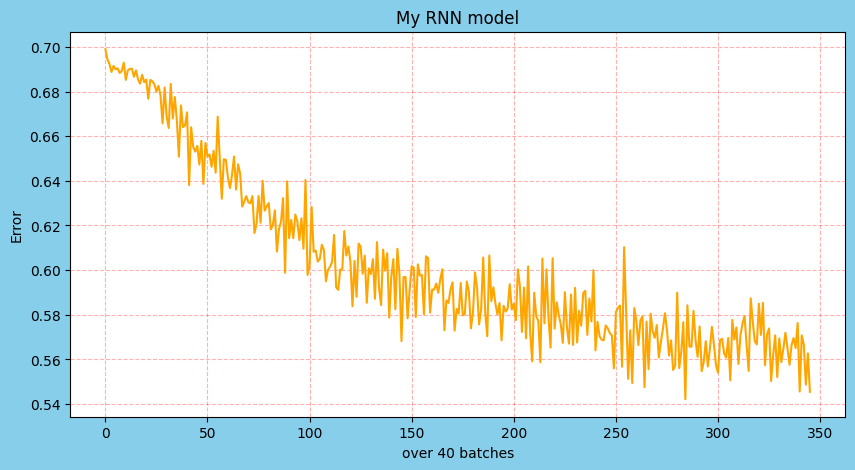

In [198]:
some_figure = plt.figure(figsize=  (10,5),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
some_ax.set_title('My RNN model')
some_ax.grid(linestyle = '--',c = 'red',alpha = 0.3)
some_ax.set_xlabel('over 40 batches')
some_ax.set_ylabel('Error')
some_ax.plot(mean_errors,color = 'orange')

<p class="task" id="6"></p>

6\. Решите предыщую задачу, заменив собственный модуль `RNN` на модули `nn.RNN`, `nn.LSTM` и `nn.GRU`. Сравните результаты работы.

- [ ] Проверено на семинаре

In [78]:
class MyRnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn1 = nn.RNN(22,20,batch_first = True)
        self.linear = nn.Linear(20,2)
    
    def forward(self,X):
        y,_ = self.rnn1(X)
        return self.linear(y)

In [86]:
rnn = MyRnnModel()
epoch = 65
lr = 0.01
optimizer = torch.optim.Adam(rnn.parameters(),lr = lr,betas = (0.9,0.99))
loss = nn.CrossEntropyLoss(weight=torch_weights,reduction='mean')

In [87]:
@torch.no_grad()
def get_score(model,set):
    test_loader = DataLoader(dataset = set,shuffle = True,batch_size=len(set))
    X,y= next(iter(test_loader))
    soft = nn.Softmax(dim = 1)
    y_pred = soft(model(X)).argmax(dim = 1).numpy()
    return round(accuracy_score(y_pred = y_pred,y_true = y),5)

In [88]:
def train_model(
        model,
        loss,
        epoch,
        the_optim,
        loader
):
    loss_list = []
    for ep in range(epoch):
        model.train()
        for X,y in loader:
            y_pred = model(X)
            batch_loss = loss(y_pred,y)
            batch_loss.backward()
            loss_list.append(round(batch_loss.item(),5))
            the_optim.step()
            the_optim.zero_grad()
        model.eval()
        accuracy_test = get_score(model,Test)
        accuracy_train = get_score(model,Train)
        if ep % 10 == 0:
            print(f'Epoch #{ep} | TrainLoss: {loss_list[-1]} | Test Accuracy: {accuracy_test} | Train Accuracy: {accuracy_train}')
    return loss_list   

In [89]:
rnn_losses = train_model(rnn,loss,epoch,optimizer,train_loader)

Epoch #0 | TrainLoss: 0.68924 | Test Accuracy: 0.55851 | Train Accuracy: 0.5656
Epoch #10 | TrainLoss: 0.69517 | Test Accuracy: 0.55142 | Train Accuracy: 0.582
Epoch #20 | TrainLoss: 0.55661 | Test Accuracy: 0.5656 | Train Accuracy: 0.60372
Epoch #30 | TrainLoss: 0.63421 | Test Accuracy: 0.60461 | Train Accuracy: 0.63697
Epoch #40 | TrainLoss: 0.54893 | Test Accuracy: 0.63121 | Train Accuracy: 0.66268
Epoch #50 | TrainLoss: 0.66392 | Test Accuracy: 0.64894 | Train Accuracy: 0.67642
Epoch #60 | TrainLoss: 0.56835 | Test Accuracy: 0.63652 | Train Accuracy: 0.66933


In [106]:
mean_errors = []
the_mean_list = []
for one_error in rnn_losses:
    if len(the_mean_list) == 15:
        mean_errors.append(sum(the_mean_list)/len(the_mean_list))
        the_mean_list.clear()
    else:
        the_mean_list.append(one_error)

In [107]:
print(len(mean_errors))

288


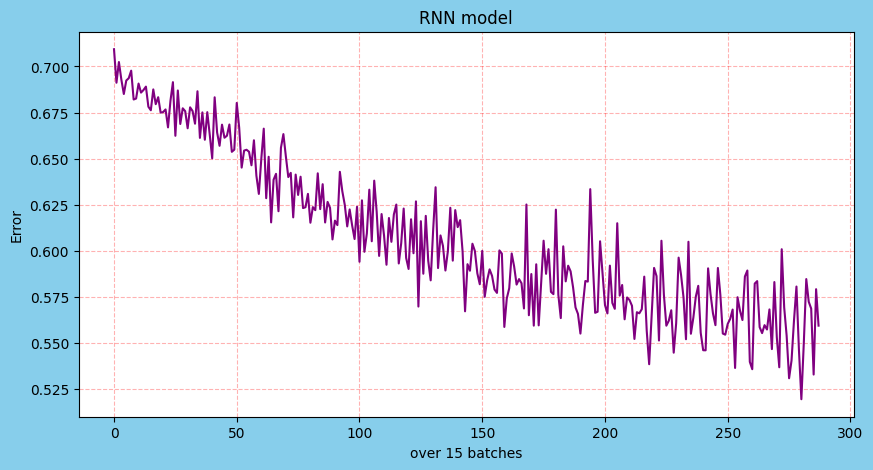

In [ ]:
some_figure = plt.figure(figsize=  (10,5),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
some_ax.set_title('RNN model')
some_ax.grid(linestyle = '--',c = 'red',alpha = 0.3)
some_ax.set_xlabel('over 15 batches')
some_ax.set_ylabel('Error')
some_ax.plot(mean_errors,color = 'purple')

In [132]:
class MyLSTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn1 = nn.LSTM(22,20,batch_first = True)
        self.linear = nn.Linear(20,2)
    
    def forward(self,X):
        y,_ = self.rnn1(X)
        return self.linear(y)

In [136]:
lstm = MyLSTModel()
epoch = 65
lr = 0.01
optimizer = torch.optim.Adam(lstm.parameters(),lr = lr,betas = (0.9,0.99))
loss = nn.CrossEntropyLoss(weight=torch_weights,reduction='mean')

In [137]:
lstm_losses = train_model(lstm,loss,epoch,optimizer,train_loader)

Epoch #0 | TrainLoss: 0.69507 | Test Accuracy: 0.47695 | Train Accuracy: 0.49246
Epoch #10 | TrainLoss: 0.69 | Test Accuracy: 0.59574 | Train Accuracy: 0.61082
Epoch #20 | TrainLoss: 0.58724 | Test Accuracy: 0.6117 | Train Accuracy: 0.65869
Epoch #30 | TrainLoss: 0.89081 | Test Accuracy: 0.66667 | Train Accuracy: 0.69858
Epoch #40 | TrainLoss: 0.5747 | Test Accuracy: 0.63652 | Train Accuracy: 0.70213
Epoch #50 | TrainLoss: 0.55065 | Test Accuracy: 0.64362 | Train Accuracy: 0.71454
Epoch #60 | TrainLoss: 0.50408 | Test Accuracy: 0.63121 | Train Accuracy: 0.70745


In [138]:
mean_errors = []
the_mean_list = []
for one_error in lstm_losses:
    if len(the_mean_list) == 15:
        mean_errors.append(sum(the_mean_list)/len(the_mean_list))
        the_mean_list.clear()
    else:
        the_mean_list.append(one_error)

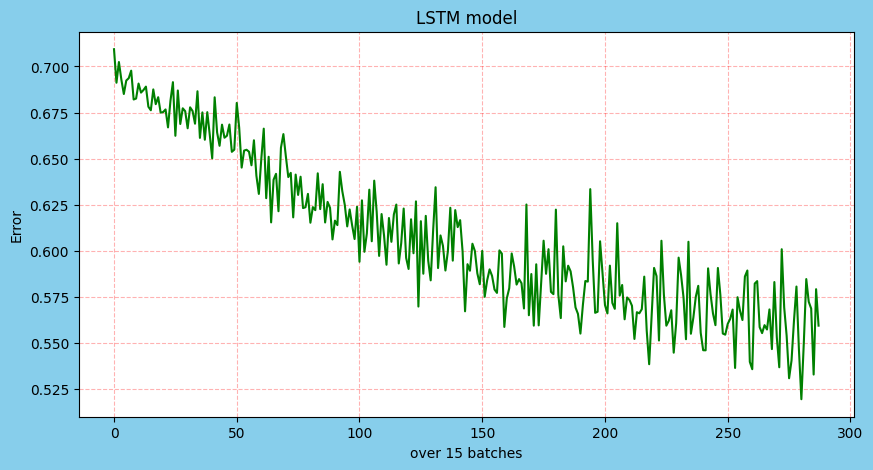

In [141]:
some_figure = plt.figure(figsize=  (10,5),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
some_ax.set_title('LSTM model')
some_ax.grid(linestyle = '--',c = 'red',alpha = 0.3)
some_ax.set_xlabel('over 15 batches')
some_ax.set_ylabel('Error')
some_ax.plot(mean_errors,color = 'green')

In [157]:
class MyGRUModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru1 = nn.GRU(22,20,batch_first = True)
        self.linear = nn.Linear(20,2)
    
    def forward(self,X):
        y,_ = self.gru1(X)
        return self.linear(y)

In [ ]:
gru = MyGRUModel()
epoch = 65
lr = 0.01
optimizer = torch.optim.Adam(gru.parameters(),lr = lr,betas = (0.9,0.99))
loss = nn.CrossEntropyLoss(weight=torch_weights,reduction='mean')

In [159]:
gru_losses = train_model(gru,loss,epoch,optimizer,train_loader)

Epoch #0 | TrainLoss: 0.68782 | Test Accuracy: 0.55674 | Train Accuracy: 0.55674
Epoch #10 | TrainLoss: 0.62221 | Test Accuracy: 0.57447 | Train Accuracy: 0.59131
Epoch #20 | TrainLoss: 0.55834 | Test Accuracy: 0.52128 | Train Accuracy: 0.53723
Epoch #30 | TrainLoss: 0.71096 | Test Accuracy: 0.55674 | Train Accuracy: 0.60727
Epoch #40 | TrainLoss: 0.64842 | Test Accuracy: 0.6383 | Train Accuracy: 0.65027
Epoch #50 | TrainLoss: 0.60869 | Test Accuracy: 0.66489 | Train Accuracy: 0.67863
Epoch #60 | TrainLoss: 0.53089 | Test Accuracy: 0.62057 | Train Accuracy: 0.6516


In [163]:
mean_errors = []
the_mean_list = []
for one_error in gru_losses:
    if len(the_mean_list) == 15:
        mean_errors.append(sum(the_mean_list)/len(the_mean_list))
        the_mean_list.clear()
    else:
        the_mean_list.append(one_error)

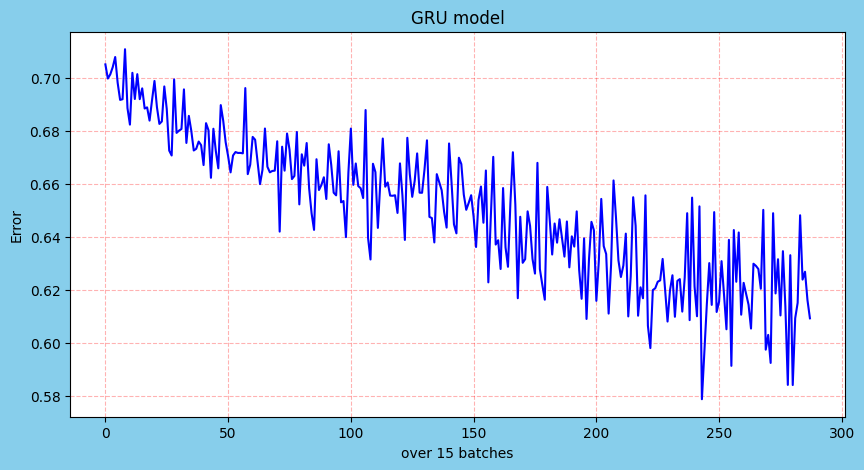

In [164]:
some_figure = plt.figure(figsize=  (10,5),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
some_ax.set_title('GRU model')
some_ax.grid(linestyle = '--',c = 'red',alpha = 0.3)
some_ax.set_xlabel('over 15 batches')
some_ax.set_ylabel('Error')
some_ax.plot(mean_errors,color = 'blue')